In [ ]:
import time
import torch
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

torch.cuda.is_available()

torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080 SUPER'

Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])
Training set size: 1641
Testing set size: 411


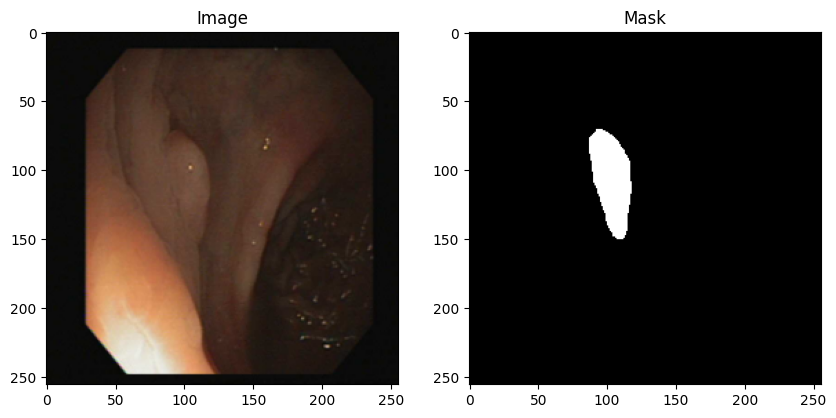

In [6]:
# Base directory containing all datasets
BASE_PATH = "DataSet"

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 256, 256

# Custom Dataset Class for Multiple Sources
class MultiSourcePolypDataset(Dataset):
    def __init__(self, base_path, transform=None):
        self.base_path = base_path
        self.transform = transform
        self.data = []
        
        # Load all image-mask pairs from multiple datasets
        for dataset_name in os.listdir(base_path):
            dataset_path = os.path.join(base_path, dataset_name)
            image_path = os.path.join(dataset_path, "images")
            mask_path = os.path.join(dataset_path, "masks")
            
            # Skip if 'images' or 'masks' folder doesn't exist
            if not os.path.exists(image_path) or not os.path.exists(mask_path):
                print(f"Skipping dataset: {dataset_name} (Missing 'images' or 'masks')")
                continue
            
            # Add all valid image-mask pairs to the dataset
            for file_name in os.listdir(image_path):
                img_file = os.path.join(image_path, file_name)
                mask_file = os.path.join(mask_path, file_name)
                if os.path.exists(mask_file):  # Ensure corresponding mask exists
                    self.data.append((img_file, mask_file))
                else:
                    print(f"Skipping file: {file_name} (No corresponding mask found)")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Load image as RGB
        mask = Image.open(mask_path).convert("L")    # Load mask as grayscale
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Binarize the mask (values: 0 or 1)
        mask = (mask > 0.5).float()
        
        return image, mask

# Transformations
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize images and masks
    transforms.ToTensor()                        # Convert to tensor and normalize [0, 1]
])

dataset = MultiSourcePolypDataset(BASE_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inspect a batch
for images, masks in dataloader:
    print(f"Image batch shape: {images.shape}")  # Shape: [batch_size, 3, IMG_HEIGHT, IMG_WIDTH]
    print(f"Mask batch shape: {masks.shape}")    # Shape: [batch_size, 1, IMG_HEIGHT, IMG_WIDTH]
    break

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Confirm dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

# Display a sample image and mask
images, masks = next(iter(train_loader))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap="gray")  # Squeeze to remove channel dimension
plt.title("Mask")
plt.show()

In [7]:
print(len(dataset))

2052


In [8]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F


In [9]:
# Initialize the model
unet_model = smp.Unet(
    encoder_name="resnet34",           # Choose encoder
    encoder_weights="imagenet",        # Use ImageNet pre-trained weights
    in_channels=3,                     # Model input channels (3 for RGB images)
    classes=1,                         # Output channels (1 for binary segmentation)
)

# Define the loss function (Binary Cross-Entropy for binary segmentation)
loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)


In [10]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)

# Training loop
train_start_time = time.time()

num_epochs = 20
for epoch in range(num_epochs):
    unet_model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_mask = unet_model(images)

        # Calculate loss
        loss = loss_fn(predicted_mask, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

train_end_time = time.time()
train_time = train_end_time - train_start_time


Epoch [1/20], Loss: 0.44105864873210204
Epoch [2/20], Loss: 0.23743567970192547
Epoch [3/20], Loss: 0.1712221221148389
Epoch [4/20], Loss: 0.13185855044612607
Epoch [5/20], Loss: 0.10697224034557065
Epoch [6/20], Loss: 0.08733837993688953
Epoch [7/20], Loss: 0.0697551808021601
Epoch [8/20], Loss: 0.05873429033796764
Epoch [9/20], Loss: 0.048810715452559945
Epoch [10/20], Loss: 0.04105007203603254
Epoch [11/20], Loss: 0.03529959993021002
Epoch [12/20], Loss: 0.03146695839331567
Epoch [13/20], Loss: 0.028488154188521856
Epoch [14/20], Loss: 0.031531987006513815
Epoch [15/20], Loss: 0.04581203261046734
Epoch [16/20], Loss: 0.047709046456130964
Epoch [17/20], Loss: 0.03108845041721191
Epoch [18/20], Loss: 0.02401869263029793
Epoch [19/20], Loss: 0.020923560991593936
Epoch [20/20], Loss: 0.018605176214743585


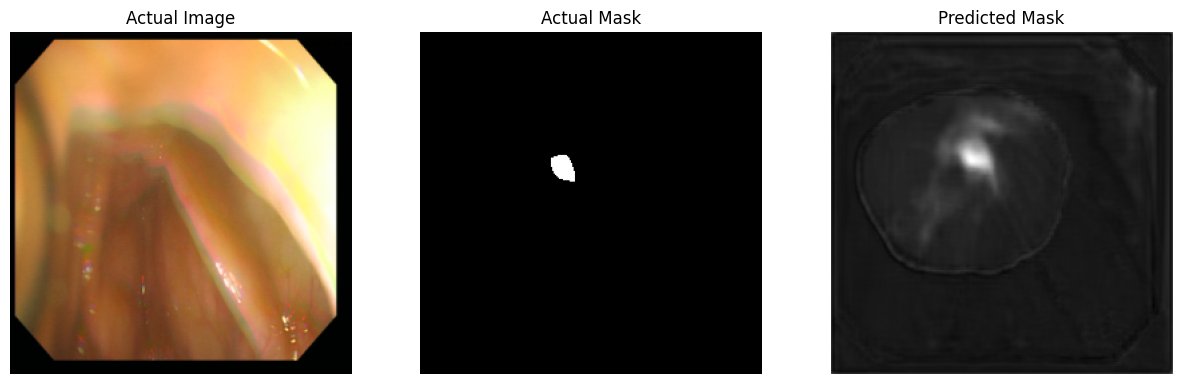

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a batch from the dataloader
images, masks = next(iter(test_loader))

# Pick the first image, mask, and predicted mask
image = images[0].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
mask = masks[0].cpu().numpy().squeeze()  # Remove channel dimension if mask is 1 channel
predicted_mask = unet_model(images.to(device))[0].cpu().detach().numpy().squeeze()  # Get the predicted mask

# Plot the actual image, actual mask, and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display image
ax[0].imshow(image)
ax[0].set_title("Actual Image")
ax[0].axis('off')

# Display actual mask
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Actual Mask")
ax[1].axis('off')

# Display predicted mask
ax[2].imshow(predicted_mask, cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()


In [13]:

# Helper functions to calculate true positives, false positives, true negatives, and false negatives
def get_metrics(pred, target, threshold=0.5):
    # Convert to binary (0 or 1) predictions and targets
    pred = (pred > threshold).float()
    target = target.float()

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = (pred * target).sum()
    FP = ((1 - target) * pred).sum()
    TN = ((1 - pred) * (1 - target)).sum()
    FN = (target * (1 - pred)).sum()

    return TP, FP, TN, FN

# 1. Dice Similarity Coefficient (DSC)
def dice_coefficient(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return (2. * TP) / (2. * TP + FP + FN + 1e-6)

# 2. Intersection over Union (IoU)
def intersection_over_union(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FP + FN + 1e-6)

# 3. Accuracy
def accuracy(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return (TP + TN) / (TP + FP + TN + FN + 1e-6)

# 4. Sensitivity (Recall)
def sensitivity(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FN + 1e-6)

# 5. Specificity
def specificity(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TN / (TN + FP + 1e-6)

# 6. Precision
def precision(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FP + 1e-6)

# 7. F1-Score
def f1_score(pred, target, threshold=0.5):
    prec = precision(pred, target, threshold)
    rec = sensitivity(pred, target, threshold)
    return 2 * (prec * rec) / (prec + rec + 1e-6)

test_start_time = time.time()
unet_model.eval()  # Set the model to evaluation mode

# Initialize empty lists to store metrics
dice_scores = []
iou_scores = []
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
precision_scores = []
f1_scores = []

# Iterate through the dataloader
for images, masks in test_loader:
    # Move tensors to GPU if necessary
    images = images.cuda()
    masks = masks.cuda()

    # Get the predicted mask from the model
    with torch.no_grad():
        predicted_mask = unet_model(images)

    # Compute the performance metrics
    dice_scores.append(dice_coefficient(predicted_mask, masks).item())
    iou_scores.append(intersection_over_union(predicted_mask, masks).item())
    accuracy_scores.append(accuracy(predicted_mask, masks).item())
    sensitivity_scores.append(sensitivity(predicted_mask, masks).item())
    specificity_scores.append(specificity(predicted_mask, masks).item())
    precision_scores.append(precision(predicted_mask, masks).item())
    f1_scores.append(f1_score(predicted_mask, masks).item())

test_end_time = time.time()
test_time = test_end_time - test_start_time
# Calculate the average performance metrics across the dataset

print(f"Total training time: {train_time:.2f}s")
print(f"Total testing time: {test_time:.2f}s")

print(f"Average Dice Coefficient: {sum(dice_scores) / len(dice_scores):.4f}")
print(f"Average Intersection over Union (IoU): {sum(iou_scores) / len(iou_scores):.4f}")
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average Sensitivity (Recall): {sum(sensitivity_scores) / len(sensitivity_scores):.4f}")
print(f"Average Specificity: {sum(specificity_scores) / len(specificity_scores):.4f}")
print(f"Average Precision: {sum(precision_scores) / len(precision_scores):.4f}")
print(f"Average F1-Score: {sum(f1_scores) / len(f1_scores):.4f}")


Total training time: 488.75s
Total testing time: 3.78s
Average Dice Coefficient: 0.9069
Average Intersection over Union (IoU): 0.8329
Average Accuracy: 0.9786
Average Sensitivity (Recall): 0.8737
Average Specificity: 0.9932
Average Precision: 0.9469
Average F1-Score: 0.9069
